In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import cirq
from scipy.optimize import minimize

import pyomo.environ as pyo

In [66]:
def solve_battery_lp(x, prices, return_vals=False):
    """
    Classical LP subproblem.
    x[t] = 1 → charging allowed
    x[t] = 0 → discharging allowed
    """
    
    T = len(prices)

    # Battery parameters
    eta = 0.8
    # eta = 1.0
    P_charge = 5.0
    P_discharge = 4.0
    E_max = 16.0
    cycle_limit = 32.0

    m = pyo.ConcreteModel()
    m.T = pyo.RangeSet(0, T - 1)

    # Variables
    m.c = pyo.Var(m.T, domain=pyo.NonNegativeReals)
    m.d = pyo.Var(m.T, domain=pyo.NonNegativeReals)
    m.e = pyo.Var(m.T, domain=pyo.NonNegativeReals)

    # Objective
    m.obj = pyo.Objective(
        expr=sum(prices[t] * (m.d[t] - m.c[t]) for t in m.T),
        sense=pyo.maximize
    )

    # SOC dynamics
    def soc_rule(m, t):
        if t == 0:
            return m.e[t] == eta * m.c[t] - m.d[t]
        return m.e[t] == m.e[t-1] + eta * m.c[t] - m.d[t]

    m.soc = pyo.Constraint(m.T, rule=soc_rule)

    # Power limits
    m.charge_limit = pyo.Constraint(
        m.T, rule=lambda m, t: m.c[t] <= P_charge * x[t]
    )
    m.discharge_limit = pyo.Constraint(
        m.T, rule=lambda m, t: m.d[t] <= P_discharge * (1 - x[t])
    )

    # SOC bound + cycle constraint
    m.soc_upper = pyo.Constraint(m.T, rule=lambda m, t: m.e[t] <= E_max)
    m.cycle_limit = pyo.Constraint(expr=sum(m.d[t] for t in m.T) <= cycle_limit)

    # Boundary SOC
    m.e[0].fix(0.0)
    m.e[T-1].fix(0.0)

    # Enable duals
    m.dual = pyo.Suffix(direction=pyo.Suffix.IMPORT)

    solver = pyo.SolverFactory("highs")
    result = solver.solve(m, tee=False)

    if result.solver.termination_condition != pyo.TerminationCondition.optimal:
        return None, None, False

    duals = {
        "mu_c": {t: m.dual[m.charge_limit[t]] for t in m.T},
        "mu_d": {t: m.dual[m.discharge_limit[t]] for t in m.T},
        "nu_e": {t: m.dual[m.soc_upper[t]] for t in m.T},
        "rho": m.dual[m.cycle_limit]
    }

    if return_vals:
        e_values = np.array([pyo.value(m.e[t]) for t in m.T])
        c_values = np.array([pyo.value(m.c[t]) for t in m.T])
        d_values = np.array([pyo.value(m.d[t]) for t in m.T])

        return pyo.value(m.obj), duals, True, e_values, c_values, d_values
    return pyo.value(m.obj), duals, True


def build_cut_coefficients(duals):
    """
    Build Benders optimality cut coefficients:
      θ ≤ α + Σ β_t x_t
    """

    beta = []
    for t in duals["mu_c"]:
        beta_t = 5.0 * duals["mu_c"][t] - 4.0 * duals["mu_d"][t]
        beta.append(beta_t)

    alpha = (
        32.0 * duals["rho"]
        + 16.0 * sum(duals["nu_e"].values())
        + 4.0 * sum(duals["mu_d"].values())
    )

    return alpha, beta


In [244]:

def initial_fixed_weight_state(qubits, K):
    """Prepare a basis state with Hamming weight K."""
    for i in range(K):
        yield cirq.X(qubits[i])


def build_qaoa_circuit(qubits, beta_coeffs, gammas, betas, K):
    circuit = cirq.Circuit()

    # Initialize in fixed-weight subspace
    circuit.append(initial_fixed_weight_state(qubits, K))
    circuit.append(cirq.H.on_each(*qubits))
    p = len(gammas)

    for layer in range(p):
        # Cost layer
        for q, b in zip(qubits, beta_coeffs):
            circuit.append(cirq.rz(2 * gammas[layer] * b)(q))

        # # XY mixer layer — preserves Hamming weight
        for i in range(len(qubits) - 1):
            circuit.append(
                cirq.ISwapPowGate(exponent=2 * betas[layer])(
                    qubits[i], qubits[i + 1]
                )
            )
        # for q in qubits:
        #     circuit.append(cirq.rx(2 * betas[layer])(q))
        

    circuit.append(cirq.measure(*qubits, key='x'))
    return circuit


def expectation(samples, beta):
    """Compute ⟨H_C⟩ = Σ β_t Z_t / 2"""
    total = 0
    for s in samples:
        z = 1 - 2 * np.array(s)   # {0,1} → {+1, -1}
        total += np.dot(beta / 2, z)
    return total / len(samples)


def run_qaoa(beta_coeffs, p, K):
    """Run QAOA with XY mixer and fixed-weight initial state."""
    n = len(beta_coeffs)
    qubits = [cirq.LineQubit(i) for i in range(n)]
    simulator = cirq.Simulator()

    def objective(params):
        gammas = params[:p]
        betas = params[p:]
        circuit = build_qaoa_circuit(qubits, beta_coeffs, gammas, betas, K)
        result = simulator.run(circuit, repetitions=10_000_000)
        return expectation(result.measurements["x"], beta_coeffs)

    init_params = np.random.uniform(0, np.pi, size=2*p)

    res = minimize(objective, init_params, method="COBYLA", options={"maxiter": 60})

    gammas = res.x[:p]
    betas = res.x[p:]
    final_circuit = build_qaoa_circuit(qubits, beta_coeffs, gammas, betas, K)
    return simulator.run(final_circuit, repetitions=10_000_000)


In [252]:
PRICE_FILE = "../data/input_data.csv"
T = 24
MAX_ITERS = 20
TOL = 1e-7
QAOA_LAYERS = 2
K = -2  # desired Hamming weight for ≤ 2 cycles

prices = (pd.read_csv(PRICE_FILE)["price"].values)[0:T]

cuts = []
LB = -1e12
UB = 1e12

x_current = np.random.randint(0, 2, size=T)

In [253]:
len(prices)

24

In [254]:
print("Starting Hybrid Benders–QAOA Solver\n")

for it in range(1, MAX_ITERS + 1):

    print(f"=== ITERATION {it} ===")

    # ---- LP: physics check ----
    obj, duals, feasible = solve_battery_lp(x_current, prices)

    if not feasible:
        raise RuntimeError("Feasibility cuts not implemented here")

    LB = max(LB, obj)

    # ---- build Benders cut ----
    alpha, beta = build_cut_coefficients(duals)
    beta = np.array(beta)
    cuts.append((alpha, beta))

    print(f"LP objective: {obj:.3f}")
    print(f"Lower bound LB: {LB:.3f}")

    # ---- update UB ----
    UB = min(UB, alpha + beta @ x_current)
    gap = UB - LB

    print(f"Upper bound UB: {UB:.3f}")
    print(f"Gap: {gap:.6f}")

    if gap <= TOL:
        print("\nConverged.")
        break

    # ---- pick cut for QAOA ----
    _, beta_for_qaoa = cuts[-1]

    # ---- QAOA ----
    qaoa_result = run_qaoa(beta_for_qaoa, QAOA_LAYERS, 2)

    samples = qaoa_result.measurements["x"]
    counts = {}

    for s in samples:
        bitstring = "".join(map(str, s[::-1]))
        counts[bitstring] = counts.get(bitstring, 0) + 1

    best = max(counts, key=counts.get)
    x_current = np.array([int(b) for b in best])

    print(f"Next x from QAOA: {x_current}\n")

print("=== FINAL ===")
print("Best schedule:", x_current)
final_obj, _, _, e_vals, c_vals, d_vals = solve_battery_lp(x_current, prices, return_vals=True)
print(f"Optimal revenue: {final_obj:.3f}")


Starting Hybrid Benders–QAOA Solver

=== ITERATION 1 ===
LP objective: 1001.990
Lower bound LB: 1001.990
Upper bound UB: 1001.990
Gap: -0.000000

Converged.
=== FINAL ===
Best schedule: [1 1 1 1 0 1 1 1 1 1 0 0 0 1 0 1 1 0 1 0 1 0 1 1]
Optimal revenue: 1001.990


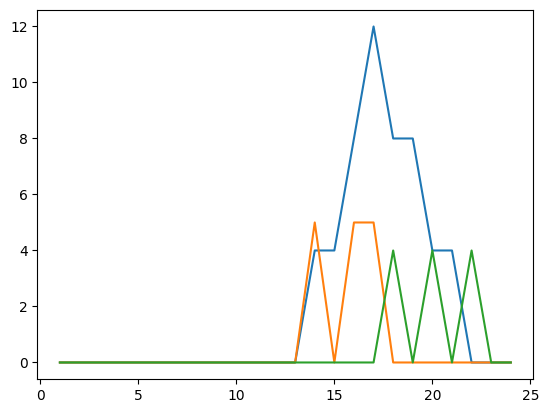

In [255]:
plt.plot(range(1,25), e_vals, label="e")
plt.plot(range(1,25), c_vals, label="c")
plt.plot(range(1,25), d_vals, label="d")

In [251]:
c_vals

array([-0., -0.,  0.,  5.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  5.,  5.,
        5.,  5.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.])

In [48]:
d_vals

array([ 0.,  0.,  0.,  0.,  0.,  0., -0., -0.,  4., -0.,  0.,  0.,  0.,
        0.,  0.,  0., -0.,  4., -0., -0.,  4.,  4., -0., -0.])